In [ ]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2023/05/30
 
@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
"""
###########################################################################
# Seminar on Quantum Technologies for Cybersecurity: Networking and Systems
# Class
# Session 5 - Quantum Security: Networking and Systems

import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:  
  import qiskit
except:
  print("installing qiskit...")
  !pip install qiskit --quiet
  print("installed qiskit.")
  import qiskit


installing qiskit...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 713.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 2.1 MB/s eta 0:00:00
installed qiskit.


In [ ]:
try:
  import sequence
  # https://github.com/sequence-toolbox/SeQUeNCe
except ImportError:
  print("installing sequence-toolbox...")
  !pip install git+https://github.com/sequence-toolbox/SeQUeNCe.git --quiet
  #!pip install sequence_toolbox --quiet
  print("installed sequence-toolbox.")
  import sequence

installing sequence-toolbox...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.5 MB/s eta 0:00:00
installed sequence-toolbox.


In [ ]:
###############################################################################
# Aggregated number of entangled memory

from ipywidgets import interact
from matplotlib import pyplot as plt
import time
from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter, BSMNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel
from sequence.resource_management.rule_manager import Rule
from sequence.entanglement_management.generation import EntanglementGenerationA
import sequence.utils.log as log

# constants
runtime = 2e10
distance = 1e3

tl = Timeline(runtime)
tl.show_progress = True

# set log
log_filename = "bb84.log"
log.set_logger(__name__, tl, log_filename)
log._log_modules=[] # Empty the list
log.set_logger_level('INFO') # 'DEBUG',  'INFO'
#log.track_module('BB84')
#log.track_module('timeline')
#log.track_module('light_source')

# our rule condition requires RAW (unentangled) memories
def eg_rule_condition(memory_info, manager, args):
  if memory_info.state == "RAW":
    return [memory_info]
  else:
    return []

# define action to be taken when we meet our condition on router 1
def eg_rule_action1(memories_info, args):
  # define requirement of protocols on other node
  def eg_req_func(protocols, args):
    for protocol in protocols:
      if isinstance(protocol, EntanglementGenerationA):
        return protocol
          
  # create entanglement generation protocol with proper parameters
  memories = [info.memory for info in memories_info]
  memory = memories[0]
  protocol = EntanglementGenerationA(None, "EGA." + memory.name, "m1", "r2", memory)
  protocol.primary = True
  
  # return values for a rule are: the protocol created, the destination node,
  # the destination codition, and arguments for the condition.
  return [protocol, ["r2"], [eg_req_func], [None]]

# define action to be taken when we meet our condition on router 2
def eg_rule_action2(memories_info, args):
  memories = [info.memory for info in memories_info]
  memory = memories[0]
  protocol = EntanglementGenerationA(None, "EGA." + memory.name, "m1", "r1", memory)
  return [protocol, [None], [None], [None]]

def test(sim_time, cc_delay, qc_atten, qc_dist):
  """
  sim_time: duration of simulation time (ms)
  cc_delay: delay on classical channels (ms)
  qc_atten: attenuation on quantum channels (db/m)
  qc_dist: distance of quantum channels (km)
  """
  
  PS_PER_MS = 1e9
  M_PER_KM = 1e3
  
  # convert units for cc delay (to ps) and qc distance (to m)
  cc_delay *= PS_PER_MS
  qc_dist *= M_PER_KM
  
  # construct the simulation timeline; the constructor argument is the simulation time (in ps)
  tl = Timeline(sim_time * PS_PER_MS)
  
  # first, construct the quantum routers
  # (with arguments for the node name, timeline, and number of quantum memories)
  r1 = QuantumRouter("r1", tl, 50)
  r2 = QuantumRouter("r2", tl, 50)
  # next, construct the BSM nodes
  # (with arguments for the node name, timeline, and the names of connected routers)
  m1 = BSMNode("m1", tl, ["r1", "r2"])
  
  r1.set_seed(0)
  r2.set_seed(1)
  m1.set_seed(2)
  
  for node in [r1, r2]:
    # get memory array object from node (note: method returns list, so access first (should be only 1))
    memory_array = node.get_components_by_type("MemoryArray")[0]
    # update coherence time parameter for node memories (measured in seconds)
    memory_array.update_memory_params("coherence_time", 0.3)
  
  # create all-to-all classical connections
  nodes = [r1, r2, m1]
  for node1 in nodes:
    for node2 in nodes:
      if node1 == node2:
        continue
      # construct a classical communication channel
      # (with arguments for the channel name, timeline, length (in m), and delay (in ps))
      cc = ClassicalChannel("_".join(["cc", node1.name, node2.name]), tl, 1e3, delay=cc_delay)
      cc.set_ends(node1, node2.name)
  
  # create linear quantum network between routers and middle node
  # for this, we create quantum channels
  # (with arguments for the channel name, timeline, attenuation (in dB/km), and distance (in m))
  qc1 = QuantumChannel("qc_r1_m1", tl, qc_atten, qc_dist)
  qc1.set_ends(r1, m1.name)
  qc2 = QuantumChannel("qc_r2_m1", tl, qc_atten, qc_dist)
  qc2.set_ends(r2, m1.name)
  
  # initialize our simulation kernel and instantiate the written rules
  tl.init()
  rule1 = Rule(10, eg_rule_action1, eg_rule_condition, None, None)
  r1.resource_manager.load(rule1)
  rule2 = Rule(10, eg_rule_action2, eg_rule_condition, None, None)
  r2.resource_manager.load(rule2)
  
  tick = time.time()
  tl.run()
  print("execution time %.2f sec" % (time.time() - tick))
  
  # display our collected metrics
  data = []
  for info in r1.resource_manager.memory_manager:
    if info.entangle_time > 0:
      data.append(info.entangle_time / 1e12)
  data.sort()
  plt.plot(data, range(1, len(data) + 1), marker="o")
  plt.xlabel("Simulation Time (s)")
  plt.ylabel("Aggregated Number of Entangled Memory")
  plt.show()

interactive_plot = interact(test, sim_time=(100, 1000, 100), cc_delay=(0.1, 10, 0.1), qc_atten=[1e-4, 2e-4, 3e-4], qc_dist=(1, 10, 1))
interactive_plot

interactive(children=(IntSlider(value=500, description='sim_time', max=1000, min=100, step=100), FloatSlider(v…

<function __main__.test(sim_time, cc_delay, qc_atten, qc_dist)>

In [ ]:
##########################################################################
# Quantum password authentication
# https://arxiv.org/abs/2103.01662
# https://github.com/goulov/qauth

# Other implementations: https://www.diva-portal.org/smash/get/diva2:20355/FULLTEXT01.pdf
# https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/chsh_game/CHSH%20game-tutorial.ipynb

from qiskit import BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import secrets
from numpy import random, pi, sin, cos, arcsin, sqrt
from scipy.optimize import minimize

# quantum computer simulator backend
backend = BasicAer.get_backend('qasm_simulator')

# protocol implementation
class qauth_simulator:
  def __init__(self, N, eps, db, user_access, levels2concurr):
      self._N = N
      self._eps = eps
      self._db = db
      self._user_access = user_access
      self._levels2concurr = levels2concurr
      self._resources = {}
      # generate resources for each user:
      for user in self._user_access.keys():
          self._resources[user] = self._generate_resources(user)

  def _get_angles(self, C):
      def W(x):
          a0, a1, b0, b1 = x
          return -0.25*( \
                  ((1+C)/2) * (cos(a0-b0)**2 + cos(a0-b1)**2 + cos(a1-b0)**2 \
                      + sin(a1-b1)**2) + \
                  ((1-C)/2) * (cos(a0+b0)**2 + cos(a0+b1)**2 + cos(a1+b0)**2 \
                      + sin(a1+b1)**2) )
      x0 = random.uniform(0, 2*pi, 4)
      sol = minimize(W,x0)
      return sol.x

  def _gen_entangled_2qbits(self, C):
      qr = QuantumRegister(2)
      qc = QuantumCircuit(qr)
      theta = 0.5*arcsin(C)
      qc.ry(2*theta, qr[0]) # *2 because bloch sphere representation
      qc.cx(qr[0], qr[1])
      return qc

  def _generate_resources(self, user):
      level = self._user_access[user]
      return self._gen_entangled_2qbits(1.0) # The input value should be smaller than 1 #self._levels2concurr[level])

  def chsh_predicate(self, s, t, ca, cb):
      return s*t == ca^cb

  def expected_nrwins_chsh(self, level):
      C = self._levels2concurr[level]
      #print(C)
      w = C**2#0.5*(0.5 + 0.25*sqrt(1+C**2))
      #print(w)
      return round(self._N*w)

  def play_chsh_run(self, user):
      C = self._levels2concurr[self._user_access[user]]
      qc = self._resources[user]
      angles = self._get_angles(C)
      
      #print(qc)
      # alice lab
      a = angles[:2]
      s = secrets.randbits(1)
      cra = ClassicalRegister(1,'c')
      qc = qc.compose(QuantumCircuit(cra))
      qa = qc.qregs[0][0]
      alpha = a[s]
      qc.ry(2*alpha, qa) # *2 because bloch sphere representation
      
      #print(qc)
      # bob lab
      b = angles[2:]
      t = secrets.randbits(1)
      crb = ClassicalRegister(1,'c')
      qc = qc.compose(QuantumCircuit(crb))
      qb = qc.qregs[0][1]
      beta = b[t]
      qc.ry(2*beta, qb) # *2 because bloch sphere representation

      #print(qc)
      # run the circuit -- "announce phase"
      qc.measure(qa, cra)
      qc.measure(qb, crb)
      job = execute(qc, backend, shots=1000)
      res = job.result().get_counts()
      #print(list(res.keys()))
      #print([int(i) for i in list(res.keys())[0].split()])
      #ca, cb = [int(i) for i in list(res.keys())[0].split()]
      ca=int(list(res.keys())[0])
      cb=int(list(res.keys())[1])
      return s, t, ca, cb

  def play_all_chsh(self, user):
      nr_wins = 0
      for _ in range(self._N):
          s, t, ca, cb = self.play_chsh_run(user)
          nr_wins += self.chsh_predicate(s, t, ca, cb)
      return nr_wins

  def authorize(self, user):
      nr_wins = self.play_all_chsh(user)
      user_level = self._user_access[user]
      expected_wins = self.expected_nrwins_chsh(user_level)
      print("runs won:", nr_wins)
      print("expected:", expected_wins)
      print("epsilon is:", self._eps)
      # authorizer checks if the number of wins is as predicted (up to eps)
      if (expected_wins - nr_wins) <= self._eps:
          print(self._db[:user_level])
      else:
          print("FORBIDDEN: failed to prove entanglement level")


if __name__ == "__main__":
  # lambda = 128, l = 4
  N = 50#16384 # number of iterations
  epsilon = int(sqrt(N))#1536 # error interval allowed

  db = ["dblevel1", "dblevel2", "dblevel3", "dblevel4"]

  levels2concurr = {1: 0.25,2: 0.5,3: 0.75,4: 1} # Numeric success levels for access

  user_access = {"user1": 1, "user2": 2,"user3": 3,"user4": 4} # Levels of access of users. so user 1 hass the lowest access level (only up to level 1), user 2 has access up to level 2, and so on

  q = qauth_simulator(N, epsilon, db, user_access, levels2concurr)
  q.authorize('user1')
  q.authorize('user2')
  q.authorize('user3')
  q.authorize('user4')

runs won: 9
expected: 3
epsilon is: 7
['dblevel1']
runs won: 14
expected: 12
epsilon is: 7
['dblevel1', 'dblevel2']
runs won: 13
expected: 28
epsilon is: 7
FORBIDDEN: failed to prove entanglement level
runs won: 11
expected: 50
epsilon is: 7
FORBIDDEN: failed to prove entanglement level


In [ ]:
try:
  import qunetsim
  # https://pypi.org/project/qunetsim/
  # https://tqsd.github.io/QuNetSim/
  # https://github.com/tqsd/QuNetSim
except ImportError:
  print("installing qunetsim...")
  !pip install qunetsim==0.1.2.post3 --quiet 
  print("installed qunetsim.")
  import qunetsim
# Note: seems that functions get_qubit, has to be changed by get_data_qubit
# Also, some name definitions instead of "", should be ''
# Also, some times exit() is place. This has to be removed, since it kills the runtime


installing qunetsim...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
installed qunetsim.


# The CHSH game

 - https://en.wikipedia.org/wiki/CHSH_inequality

 == CHSH game ==
The '''CHSH game''' is a thought experiment involving two parties separated at a great distance (far enough to preclude classical communication at the speed of light), each of whom has access to one half of an entangled two-qubit pair. Analysis of this game shows that no classical [[local hidden-variable theory]] can explain the correlations that can result from entanglement. Since this game is indeed physically realizable, this gives strong evidence that classical physics is fundamentally incapable of explaining certain quantum phenomena, at least in a "local" fashion.

In the CHSH game, there are two cooperating players, Alice and Bob, and a referee, Charlie. These agents will be abbreviated <math>A, B, C</math> respectively. At the start of the game, Charlie chooses bits <math>x,y \in \{0,1\}</math> uniformly at random, and then sends <math>x</math> to Alice and <math>y</math> to Bob. Alice and Bob must then each respond to Charlie with bits <math>a,b \in \{0,1\}</math> respectively. Now, once Alice and Bob send their responses back to Charlie, Charlie tests if <math>a \oplus b = x \land y</math>. If this equality holds, then Alice and Bob win, and if not then they lose.

It is also required that Alice and Bob's responses can only depend on the bits they see: so Alice's response <math>a</math> depends only on <math>x</math>, and similarly for Bob. This means that Alice and Bob are forbidden from directly communicating with each other about the values of the bits sent to them by Charlie. However, Alice and Bob are allowed to decide on a common ''strategy'' before the game begins.

In the following sections, it is shown that if Alice and Bob use only classical strategies involving their local information (and potentially some random coin tosses), it is impossible for them to win with a probability higher than 75%. However, if Alice and Bob are allowed to share a single entangled qubit pair, then there exists a strategy which allows Alice and Bob to succeed with a probability of ~85%.

=== Optimal classical strategy ===
We first establish that any ''[[Determinism|deterministic]]'' classical strategy has success probability at most 75% (where the probability is taken over Charlie's uniformly random choice of <math>x,y</math>). By a deterministic strategy, we mean a pair of functions <math>f_A, f_B: \{0,1\} \mapsto \{0,1\}</math>, where <math>f_A</math> is a function determining Alice's response as a function of the message she receives from Charlie, and <math>f_B</math> is a function determining Bob's response based on what he receives. To prove that any deterministic strategy fails at least 25% of the time, we can simply consider all possible pairs of strategies for Alice and Bob, of which there are at most 8 (for each party, there are 4 functions <math>\{0,1\} \mapsto \{0,1\}</math>). It can be verified that for each of those 8 strategies there is always at least one out of the four possible input pairs <math>(x, y) \in \{0,1\}^2</math> which makes the strategy fail. For example, in the strategy where both players always answer 0, we have that Alice and Bob win in all cases except for when <math>x=y=1</math>, so using this strategy their win probability is exactly 75%.

Now, consider the case of randomized classical strategies, where Alice and Bob have access to ''correlated'' random numbers. They can be produced by jointly flipping a coin several times before the game has started and Alice and Bob are still allowed to communicate. The output they give at each round is then a function of both Charlie's message and the outcome of the corresponding coin flip. Such a strategy can be viewed as a probability distribution over deterministic strategies, and thus its success probability is a weighted sum over the success probabilities of the deterministic strategies. But since every deterministic strategy has a success probability of at most 75%, this weighted sum cannot exceed 75% either.

=== Optimal quantum strategy ===

Now, imagine that Alice and Bob each possess one qubit of the following 2-qubit entangled state: <math display="inline">\Phi = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)</math>. This state is commonly referred to as the [[Bell state|EPR pair]], and can be equivalently written as <math display="inline">\Phi = \frac{1}{\sqrt{2}}(|++\rangle + |--\rangle)</math>. Alice and Bob will use this entangled pair in their strategy as described below. The optimality of this strategy follows from [[Tsirelson's bound]].

When Alice receives her bit <math>x</math> from Charlie, if <math>x=0</math> she will measure her qubit in the basis <math>|0\rangle, |1\rangle</math>, and then respond with 0 if the measurement outcome is <math>|0\rangle</math>, and 1 if it is <math>|1\rangle</math>. 

Otherwise, if <math>x=1</math> she will measure her qubit in the basis <math>|+\rangle, |-\rangle</math>, and respond with 0 if the measurement outcome is <math>|+\rangle</math>, and 1 if it is <math>|-\rangle</math>.

When Bob receives his bit <math>y</math> from Charlie, if <math>y=0</math> he will measure his qubit in the basis <math>|a_0\rangle, |a_1\rangle</math> where <math display="inline">|a_0\rangle = \left(\cos\frac{\pi}{8}\right)|0\rangle + \left(\sin\frac{\pi}{8}\right)|1\rangle</math>, and <math display="inline">|a_1\rangle = \left(-\sin\frac{\pi}{8}\right)|0\rangle + \left(\cos\frac{\pi}{8}\right)|1\rangle</math>. He then responds with 0 if the result is <math>|a_0\rangle</math>, and 1 if it is <math>|a_1\rangle</math>. 

Otherwise, if <math>y=1</math>, he will measure his qubit in the basis <math>|b_0\rangle, |b_1\rangle</math> where <math display="inline">|b_0\rangle = \left(\cos\frac{\pi}{8}\right)|0\rangle - \left(\sin\frac{\pi}{8}\right)|1\rangle</math>, and <math display="inline">|b_1\rangle = (\sin\frac{\pi}{8})|0\rangle + \left(\cos\frac{\pi}{8}\right)|1\rangle</math>. In this case, he responds with 0 if the result is <math>|b_0\rangle</math>, and 1 if it is <math>|b_1\rangle</math>.

To analyze the success probability, it suffices to analyze the probability that they output a winning value pair on each of the four possible inputs <math>(x,y)</math>, and then take the average. We analyze the case where <math>x=y=0</math> here:
In this case the winning response pairs are <math>a = b = 0</math> and <math>a=b=1</math>. On input <math>x=y=0</math>, we know that Alice will measure in the basis <math>|0\rangle, |1\rangle</math>, and Bob will measure in the basis <math>|a_0\rangle, |a_1\rangle</math>. Then the probability that they both output 0 is the same as the probability that their measurements yield <math>|0\rangle, |a_0\rangle</math> respectively, so precisely <math display="inline">|(\langle 0|\otimes \langle a_0|) |\Phi \rangle|^2 = \frac{1}{2}\cos^2\left(\frac{\pi}{8}\right)</math>. Similarly, the probability that they both output 1 is exactly <math display="inline">|(\langle 1|\otimes \langle a_1|) |\Phi \rangle|^2 = \frac{1}{2}\cos^2\left(\frac{\pi}{8}\right)</math>. So the probability that either of these successful outcomes happens is <math display="inline">\cos^2\left(\frac{\pi}{8}\right)</math>.

In the case of the 3 other possible input pairs, essentially identical analysis shows that Alice and Bob will have the same win probability of <math>\cos^2\left(\frac{\pi}{8}\right)</math>, so overall the average win probability for a randomly chosen input is <math display="inline">\cos^2\left(\frac{\pi}{8}\right)</math>. Since <math display="inline">\cos^2\left(\frac{\pi}{8}\right) \approx 85\%</math>, this is strictly better than what was possible in the classical case.

=== Modeling general quantum strategies ===

An arbitrary quantum strategy for the CHSH game can be modeled as a triple <math>\mathcal{S} = \left(|\psi\rangle, (A_{0}, A_1), (B_0, B_1)\right)</math> where 
* <math>|\psi\rangle \in \mathbb{C}^d \otimes \mathbb{C}^d</math> is a bipartite state for some <math>d</math>,
* <math>A_{0}</math> and <math>A_{1}</math> are Alice's [[Observable|observables]] each corresponding to receiving <math>x\in\{0,1\}</math> from the referee, and
* <math>B_{0}</math> and <math>B_{1}</math> are Bob's observables each corresponding to receiving <math>y\in\{0,1\}</math> from the referee.
The optimal quantum strategy described above can be recast in this notation as follows: <math>|\psi\rangle \in\mathbb{C}^2\otimes\mathbb{C}^2</math> is the EPR pair <math display="inline">|\psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)</math>, the observable <math>A_0 = Z</math> (corresponding to Alice measuring in the <math>\{|0\rangle, |1\rangle\}</math> basis), the observable <math>A_1 = X</math> (corresponding to Alice measuring in the <math>\{|+\rangle, |-\rangle\}</math> basis), where <math>X</math> and <math>Z</math> are [[Pauli matrices]]. The observables <math display="inline">B_{0} = \frac{1}{\sqrt{2}}(X+Z)</math> and <math display="inline">B_{1} = \frac{1}{\sqrt{2}}(Z-X)</math> (corresponding to each of Bob's choice of basis to measure in). 
We will denote the success probability of a strategy <math>\mathcal{S}</math> in the CHSH game by <math>\omega^*_{\text{CHSH}}(\mathcal{S})</math>, and we define the ''bias'' of the strategy <math>\mathcal{S}</math> as <math>\beta^*_{\text{CHSH}}(\mathcal{S}) := 2\omega^*_{\text{CHSH}}(\mathcal{S}) - 1</math>, which is the difference between the winning and losing probabilities of <math>\mathcal{S}</math>.

In particular, we have 
<math display="block">
\beta^*_{\text{CHSH}}(\mathcal{S}) = \frac{1}{4} \sum_{x,y \in \{0,1\}} (-1)^{x\wedge y} \cdot \langle \psi | A_x\otimes B_y |\psi\rangle.
</math>
The bias of the quantum strategy described above is <math display="inline">\frac{1}{\sqrt{2}}</math>.

=== Tsirelson's inequality and CHSH rigidity ===

{{See also|Tsirelson's bound}}

Tsirelson's inequality, discovered by [[Boris Tsirelson]] in 1980,<ref>{{Cite web|url=https://www.tau.ac.il/~tsirel/download/qbell80.html | title=Quantum generalizations of Bell's inequality|website=www.tau.ac.il}}</ref> states that for any quantum strategy <math>\mathcal{S}</math> for the CHSH game, the bias <math display="inline">\beta^*_{\text{CHSH}}(\mathcal{S}) \leq \frac{1}{\sqrt{2}}</math>. Equivalently, it states that success probability
<math display="block">\omega^*_{\text{CHSH}}(\mathcal{S}) \leq  \cos^2\left(\frac{\pi}{8}\right) = \frac{1}{2} + \frac{1}{2\sqrt{2}}</math>
for any quantum strategy <math>\mathcal{S}</math> for the CHSH game. In particular, this implies the optimality of the quantum strategy described above for the CHSH game.

Tsirelsen's inequality establishes that the maximum success probability of ''any'' quantum strategy is <math display="inline">\cos^2\left(\frac{\pi}{8}\right)</math>, and we saw that this maximum success probability is achieved by the quantum strategy described above. In fact, any quantum strategy that achieves this maximum success probability must be isomorphic (in a precise sense) to the canonical quantum strategy described above; this property is called the ''rigidity'' of the CHSH game, first attributed to Summers and Werner.<ref>[https://projecteuclid.org/journals/communications-in-mathematical-physics/volume-110/issue-2/Maximal-violation-of-Bells-inequalities-is-generic-in-quantum-field/cmp/1104159237.full Maximal violation of Bell's inequalities is generic in quantum field theory, Summers and Werner (1987)]</ref>  More formally, we have the following result: 

{{math theorem | name = Theorem (Exact CHSH rigidity) | math_statement = Let <math>\mathcal{S} = \left(|\psi\rangle, (A_0, A_1), (B_0, B_1)\right)</math> be a quantum strategy for the CHSH game where <math>|\psi\rangle \in \mathcal{A}\otimes\mathcal{B}</math> such that <math display="inline">\omega_{\text{CHSH}}(\mathcal{S}) = \cos^2\left(\frac{\pi}{8}\right)</math>. Then there exist [[isometries]] <math>V : \mathcal{A}\to\mathcal{A}_1\otimes\mathcal{A}_2</math> and <math>W : \mathcal{B}\to\mathcal{B}_1\otimes\mathcal{B}_2</math> where <math>\mathcal{A}_1,\mathcal{B}_1</math> are isomorphic to <math>\mathbb{C}^2</math> such that letting <math>|\theta\rangle = (V\otimes W)|\psi\rangle</math> we have 
<math display ="block">
|\theta\rangle = |\Phi\rangle_{\mathcal{A}_1, \mathcal{B}_1} \otimes |\phi\rangle_{\mathcal{A}_2,\mathcal{B}_2}
</math>
where <math display="inline">|\Phi\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right)</math> denotes the EPR pair and <math>|\phi\rangle_{\mathcal{A}_2,\mathcal{B}_2}</math> denotes some pure state, and 
<math display ="block">\begin{align}
(V\otimes W)A_0|\psi\rangle = Z_{\mathcal{A}_1}|\theta\rangle, & \qquad (V\otimes W)B_0|\psi\rangle = Z_{\mathcal{B}_1}|\theta\rangle,\\
(V\otimes W)A_1|\psi\rangle = X_{\mathcal{A}_1}|\theta\rangle, & \qquad (V\otimes W)B_1|\psi\rangle = Z_{\mathcal{B}_1}|\theta\rangle.
\end{align}</math>}}

Informally, the above theorem states that given an arbitrary optimal strategy for the CHSH game, there exists a local change-of-basis (given by the isometries <math>V, W</math>) for Alice and Bob such that their shared state <math>|\psi\rangle</math> factors into the tensor of an EPR pair <math>|\Phi\rangle</math> and an additional auxiliary state <math>|\phi\rangle</math>. Furthermore, Alice and Bob's observables <math>(A_0, A_1)</math> and <math>(B_0, B_1)</math> behave, up to unitary transformations, like the <math>Z</math> and <math>X</math> observables on their respective qubits from the EPR pair. An ''approximate'' or ''quantitative'' version of CHSH rigidity was obtained by McKague, et al.<ref>{{Cite journal | url=http://dx.doi.org/10.1088/1751-8113/45/45/455304|title=Robust self-testing of the singlet|first1=M|last1=McKague|first2=T H|last2=Yang|first3=V|last3=Scarani|date=October 19, 2012|journal=Journal of Physics A: Mathematical and Theoretical |volume=45 |issue=45|pages=455304|doi=10.1088/1751-8113/45/45/455304|arxiv=1203.2976|s2cid=118535156 }}</ref> who proved that if you have a quantum strategy <math>\mathcal{S}</math> such that <math display="inline">\omega_{\text{CHSH}}(\mathcal{S}) = \cos^2\left(\frac{\pi}{8}\right) - \epsilon</math> for some <math>\epsilon > 0</math>, then there exist isometries under which the strategy <math>\mathcal{S}</math> is <math>O(\sqrt{\epsilon})</math>-close to the canonical quantum strategy. Representation-theoretic proofs of approximate rigidity are also known.<ref>{{Cite web|url=http://users.cms.caltech.edu/~vidick/ucsd_games.pdf|title=UCSD Summer School Notes: Quantum multiplayer games, testing and rigidity, Thomas Vidick (2018)}}</ref>

=== Applications ===

Note that the CHSH game can be viewed as a ''test'' for quantum entanglement and quantum measurements, and that the rigidity of the CHSH game lets us test for a ''specific'' entanglement as well as ''specific'' quantum measurements. This in turn can be leveraged to test or even verify entire quantum computations—in particular, the rigidity of CHSH games has been harnessed to construct protocols for verifiable quantum delegation,<ref>{{Cite journal|url=http://arxiv.org/abs/1708.07359|title=Verifier-on-a-Leash: new schemes for verifiable delegated quantum computation, with quasilinear resources|first1=Andrea|last1=Coladangelo |first2=Alex|last2=Grilo|first3=Stacey|last3=Jeffery|first4=Thomas|last4=Vidick|date=January 9, 2020|via=arXiv.org |arxiv=1708.07359}}</ref><ref>{{Cite journal|url=http://arxiv.org/abs/1711.09585|title=A simple protocol for verifiable delegation of quantum computation in one round|first=Alex B.|last=Grilo|date=June 5, 2020|via=arXiv.org|arxiv=1711.09585}}</ref> certifiable randomness expansion,<ref>{{Cite journal|url=http://arxiv.org/abs/1111.6054|title=Certifiable Quantum Dice - Or, testable exponential randomness expansion|first1=Umesh V.|last1=Vazirani|first2=Thomas|last2=Vidick|date=November 25, 2011 |via=arXiv.org |arxiv=1111.6054}}</ref> and device-independent cryptography.<ref>{{Cite journal|url=http://arxiv.org/abs/1210.1810 |title=Fully device independent quantum key distribution|first1=Umesh|last1=Vazirani |first2=Thomas|last2=Vidick |date=September 29, 2014|journal=Physical Review Letters|volume=113|issue=14|pages=140501|via=arXiv.org |doi=10.1103/PhysRevLett.113.140501 |pmid=25325625 |arxiv=1210.1810|s2cid=119299119 }}</ref>

Starting game. Strategy: QUANTUM
Generating initial entanglement...
created 1 EPR pairs
created 2 EPR pairs
created 3 EPR pairs
created 4 EPR pairs
created 5 EPR pairs
created 6 EPR pairs
created 7 EPR pairs
created 8 EPR pairs
created 9 EPR pairs
created 10 EPR pairs
created 11 EPR pairs
created 12 EPR pairs
created 13 EPR pairs
created 14 EPR pairs
created 15 EPR pairs
created 16 EPR pairs
created 17 EPR pairs
created 18 EPR pairs
created 19 EPR pairs
created 20 EPR pairs
Done generating initial entanglement


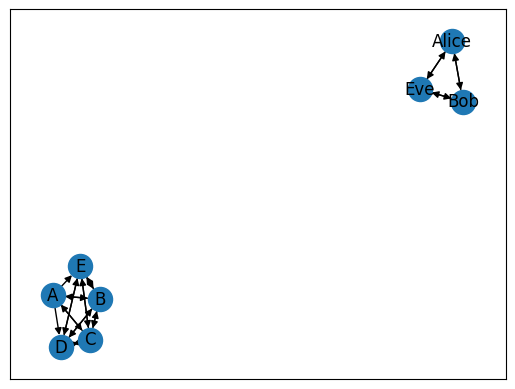

X, Y, A, B --- 1, 1, 1, 0
Winners!
X, Y, A, B --- 0, 0, 1, 1
Winners!
X, Y, A, B --- 1, 1, 1, 0
Winners!
X, Y, A, B --- 0, 0, 1, 1
Winners!
X, Y, A, B --- 1, 0, 1, 1
Winners!
X, Y, A, B --- 0, 1, 1, 1
Winners!
X, Y, A, B --- 1, 1, 1, 0
Winners!
X, Y, A, B --- 0, 0, 0, 0
Winners!
X, Y, A, B --- 0, 1, 1, 1
Winners!
X, Y, A, B --- 1, 1, 1, 0
Winners!
X, Y, A, B --- 0, 0, 1, 1
Winners!
X, Y, A, B --- 0, 1, 1, 1
Winners!
X, Y, A, B --- 1, 0, 0, 0
Winners!
X, Y, A, B --- 0, 1, 1, 1
Winners!
X, Y, A, B --- 1, 0, 0, 0
Winners!
X, Y, A, B --- 0, 1, 0, 0
Winners!
X, Y, A, B --- 1, 1, 0, 1
Winners!
X, Y, A, B --- 1, 0, 0, 0
Winners!
X, Y, A, B --- 0, 1, 0, 0
Winners!
X, Y, A, B --- 0, 0, 0, 0
Winners!
Win ratio: 100.00%


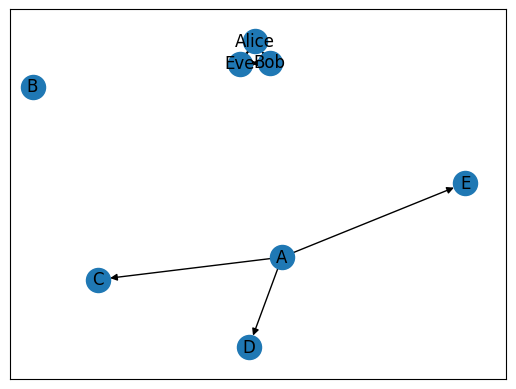

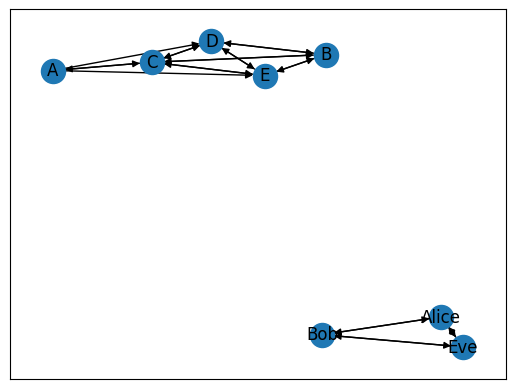

In [ ]:
##########################################################################
# CHSH game
import math
import random
from qunetsim.components import Host
from qunetsim.components import Network
from qunetsim import Logger

Logger.DISABLED = True
PLAYS = 20

def alice_classical(alice_host, referee_id):
  """
  Alice's classical strategy.
  Args:
    alice_host:
    referee_id:
  """
  # Here we write the protocol code for a host.
  for i in range(PLAYS):
    _ = alice_host.get_next_classical(referee_id, wait=5)
    alice_host.send_classical(referee_id, "0")


def alice_quantum(alice_host, referee_id, bob_id):
  """
  Alice's quantum protocol for the CHSH game.
  Args:
      alice_host (Host): Alice's Host object
      referee_id (str): Referee's Host ID
      bob_id (str): Bob's Host ID (only for accessing shared EPR pairs)
  """
  for i in range(PLAYS):
    referee_message = alice_host.get_next_classical(referee_id, wait=5)
    x = int(referee_message.content)
    epr = alice_host.get_epr(bob_id)

    if x == 0:
      res = epr.measure()
      alice_host.send_classical(referee_id, str(res))
    else:
      epr.H()
      res = epr.measure()
      alice_host.send_classical(referee_id, str(res))


def bob_classical(bob_host, referee_id):
  # Here we write the protocol code for another host.
  for i in range(PLAYS):
    _ = bob_host.get_next_classical(referee_id, wait=5)
    bob_host.send_classical(referee_id, "0")

def bob_quantum(bob_host, referee_id, alice_id):
  """
      Bob's quantum protocol for the CHSH game.
      Args:
          bob_host (Host): Bob's Host object
          referee_id (str): Referee's Host ID
          alice_id (str): Alice's Host ID (only for accessing shared EPR pairs)
  """

  for i in range(PLAYS):
    referee_message = bob_host.get_next_classical(referee_id, wait=5)

    y = int(referee_message.content)
    epr = bob_host.get_epr(alice_id)

    if y == 0:
      epr.ry(-2.0 * math.pi / 8.0)
      res = epr.measure()
      bob_host.send_classical(referee_id, str(res))
    else:
      epr.ry(2.0 * math.pi / 8.0)
      res = epr.measure()
      bob_host.send_classical(referee_id, str(res))


def referee(ref, alice_id, bob_id):
  """
  Referee protocol for CHSH game.
  Args:
      ref (Host): Referee host object
      alice_id (str): Alice's host ID
      bob_id (str): Bob's host ID
  """

  wins = 0
  for i in range(PLAYS):
    x = random.choice([0, 1])
    ref.send_classical(alice_id, str(x))
    y = random.choice([0, 1])
    ref.send_classical(bob_id, str(y))

    alice_response = ref.get_next_classical(alice_id, wait=5)
    bob_response = ref.get_next_classical(bob_id, wait=5)

    a = int(alice_response.content)
    b = int(bob_response.content)

    print('X, Y, A, B --- %d, %d, %d, %d' % (x, y, a, b))
    if (x & y) == (a ^ b):
      print('Winners!')
      wins += 1
    else:
      print('Losers!')

  print("Win ratio: " + "{0:.2%}".format(1. * wins / PLAYS))

def main():
  network = Network.get_instance()
  network.start()
  network.delay = 0.0

  host_A = Host('A')
  host_A.add_c_connection('C')
  host_A.delay = 0
  host_A.start()

  host_B = Host('B')
  host_B.add_c_connection('C')
  host_B.delay = 0
  host_B.start()

  host_C = Host('C')
  host_C.add_c_connections(['A', 'B'])
  host_C.delay = 0
  host_C.start()

  network.add_host(host_C)

  # To generate entanglement
  host_A.add_connection('B')
  host_B.add_connection('A')

  network.add_host(host_A)
  network.add_host(host_B)

  # strategy = 'CLASSICAL'
  strategy = 'QUANTUM'

  host_A.delay = 0.0
  host_B.delay = 0.0
  host_C.delay = 0.0

  print('Starting game. Strategy: %s' % strategy)
  if strategy == 'QUANTUM':
      print('Generating initial entanglement...')
      for i in range(PLAYS):
          host_A.send_epr('B', await_ack=True)
          print('created %d EPR pairs' % (i + 1))
      print('Done generating initial entanglement')
  else:
      network.delay = 0.0

  network.draw_classical_network()
  # Remove the connection from Alice and Bob
  host_A.remove_connection('B')
  host_B.remove_connection('A')

  # Play the game classically
  if strategy == 'CLASSICAL':
      host_A.run_protocol(alice_classical, (host_C.host_id,))
      host_B.run_protocol(bob_classical, (host_C.host_id,), )

  # Play the game quantumly
  if strategy == 'QUANTUM':
      host_A.run_protocol(alice_quantum, (host_C.host_id, host_B.host_id))
      host_B.run_protocol(bob_quantum, (host_C.host_id, host_A.host_id))

  host_C.run_protocol(referee, (host_A.host_id, host_B.host_id), blocking=True)

  network.stop(True)
  network.draw_quantum_network()
  network.draw_classical_network()

main()